In [99]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Dataset

In [100]:
data_file = 'HARGA RUMAH JAKSEL.xlsx'
df = pd.read_excel(data_file)
print(df.head())

         HARGA    LT   LB  JKT  JKM  GRS    KOTA
0  28000000000  1100  700    5    6  ADA  JAKSEL
1  19000000000   824  800    4    4  ADA  JAKSEL
2   4700000000   500  400    4    3  ADA  JAKSEL
3   4900000000   251  300    5    4  ADA  JAKSEL
4  28000000000  1340  575    4    5  ADA  JAKSEL


# 2. Exploratory Data Analysis

In [101]:
print("Dataset Overview:\n", df.head())
print("\nSummary Statistics:\n", df.describe(include='all'))
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

Dataset Overview:
          HARGA    LT   LB  JKT  JKM  GRS    KOTA
0  28000000000  1100  700    5    6  ADA  JAKSEL
1  19000000000   824  800    4    4  ADA  JAKSEL
2   4700000000   500  400    4    3  ADA  JAKSEL
3   4900000000   251  300    5    4  ADA  JAKSEL
4  28000000000  1340  575    4    5  ADA  JAKSEL

Summary Statistics:
                HARGA           LT            LB          JKT          JKM  \
count   1.001000e+03  1001.000000   1001.000000  1001.000000  1001.000000   
unique           NaN          NaN           NaN          NaN          NaN   
top              NaN          NaN           NaN          NaN          NaN   
freq             NaN          NaN           NaN          NaN          NaN   
mean    1.747472e+10   530.504496    487.275724     4.457542     3.940060   
std     2.079548e+10   531.069773    452.872262     2.004606     1.903261   
min     4.300000e+08    22.000000     38.000000     1.000000     1.000000   
25%     6.750000e+09   220.000000    300.000000  

# 3. Data Preprocessing
## Handling missing values

In [102]:
df = df.dropna()

## Converting categorical columns to numeric using LabelEncoder

In [103]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Converting columns to numeric if possible

In [104]:
def convert_to_numeric(column):
    try:
        return pd.to_numeric(column, errors='coerce')
    except:
        return column

df = df.apply(convert_to_numeric)

# Selecting numerical features for clustering

In [105]:
numerical_features_without_harga = [col for col in numerical_features if col != 'HARGA']

# Ensure all numerical features have valid values

In [106]:
for col in numerical_features_without_harga :
    if not np.isfinite(df[col]).all():  
        raise ValueError(f"Non-finite values detected in column: {col}")

scaler = StandardScaler()
scaler.fit(df[numerical_features_without_harga].values)  # Gunakan .values untuk array
scaled_data = scaler.transform(df[numerical_features_without_harga].values)

# 4. Clustering

In [114]:
if 'Price' in df.columns:
    price_data = df[['Price']]
    price_scaled = scaler.fit_transform(price_data)

    # Clustering with three clusters (Murah, Sedang, Mahal)
    kmeans_price = KMeans(n_clusters=3, random_state=42)
    df['Price_Cluster'] = kmeans_price.fit_predict(price_scaled)

    # Identify clusters for Murah, Sedang, Mahal
    cluster_means = df.groupby('Price_Cluster')['Price'].mean()
    cluster_mapping = {
        cluster_means.idxmin(): 'Murah',
        cluster_means.idxmax(): 'Mahal',
    }
    remaining_cluster = set(cluster_means.index) - set(cluster_mapping.keys())
    for cluster in remaining_cluster:
        cluster_mapping[cluster] = 'Sedang'

    df['Price_Cluster_Label'] = df['Price_Cluster'].map(cluster_mapping)

    print("\nCluster Mapping (Price):", cluster_mapping)
    print("Clustered Data:\n", df[['Price', 'Price_Cluster_Label']].head())

    # Visualize Price Clusters
    sns.boxplot(data=df, x='Price_Cluster_Label', y='Price', palette='Set2')
    plt.title('Distribusi Harga Berdasarkan Cluster')
    plt.show()


# General Clustering and PCA visualization

e:\Akbar\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
e:\Akbar\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Silhouette Score: 0.47


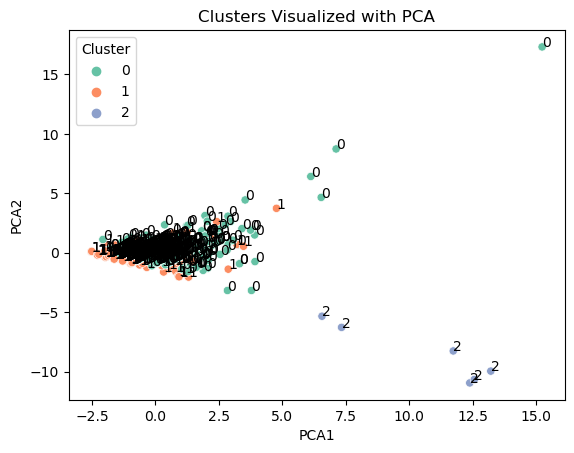

In [115]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)
silhouette_avg = silhouette_score(scaled_data, df['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
df['PCA1'] = reduced_data[:, 0]
df['PCA2'] = reduced_data[:, 1]
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
for i, txt in enumerate(df['Cluster']):
    plt.annotate(txt, (df['PCA1'].iloc[i], df['PCA2'].iloc[i]))
plt.title('Clusters Visualized with PCA')
plt.show()

# 5. Classification

In [109]:
X = df[numerical_features_without_harga]
y = df['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using Random Forest for Classification

In [110]:
classifier = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
classifier = grid_search.best_estimator_
print(f"Best Parameters for Classification: {grid_search.best_params_}")

y_pred = classifier.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Best Parameters for Classification: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       159
           1       0.98      1.00      0.99        41
           2       0.00      0.00      0.00         1

    accuracy                           1.00       201
   macro avg       0.66      0.67      0.66       201
weighted avg       0.99      1.00      0.99       201

Accuracy Score: 0.9950248756218906


e:\Akbar\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Akbar\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Akbar\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
df.columns

Index(['HARGA', 'LT', 'LB', 'JKT', 'JKM', 'GRS', 'KOTA', 'Cluster', 'PCA1',
       'PCA2'],
      dtype='object')

# 6. Price Prediction

In [112]:
if 'HARGA' in df.columns:
    price_features = [col for col in numerical_features_without_harga]
    X_price = df[price_features]
    y_price = df['HARGA']

    X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

    price_model = RandomForestRegressor(random_state=42)
    param_grid_reg = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    grid_search_reg = GridSearchCV(estimator=price_model, param_grid=param_grid_reg, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search_reg.fit(X_price_train, y_price_train)
    price_model = grid_search_reg.best_estimator_
    print(f"Best Parameters for Price Prediction: {grid_search_reg.best_params_}")

    y_price_pred = price_model.predict(X_price_test)
    mae = mean_absolute_error(y_price_test, y_price_pred)
    rmse = np.sqrt(mean_squared_error(y_price_test, y_price_pred))
    print("\nPrice Prediction Model Performance:")
    print(f"R^2 Score: {price_model.score(X_price_test, y_price_test):.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

    # Deployment function for price prediction
    def predict_price(input_data):
        """Predict the price for new input data."""
        input_scaled = scaler.transform([input_data])
        return price_model.predict([input_scaled[0][:len(price_features)]])[0]

    # Example Input for Price Prediction
    example_price_input = [500, 1, 2, 3, 0, 0]
    predicted_price = predict_price(example_price_input)
    print(f"Example Input for Price Prediction: {example_price_input}")
    print(f"Predicted Price: {predicted_price}")
else:
    print("Price column not found in the dataset. Price prediction cannot be performed.")

Best Parameters for Price Prediction: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}

Price Prediction Model Performance:
R^2 Score: 0.55
Mean Absolute Error (MAE): 4415111989.22
Root Mean Square Error (RMSE): 8209497780.14
Example Input for Price Prediction: [500, 1, 2, 3, 0, 0]
Predicted Price: 643178237.4247481


e:\Akbar\Anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
